In [1]:
from tyxe_runfiles import train, generate, eval
#from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine

In [2]:
BASE_DIR = "./tests/sanity_check"
PROFILE = "tyxe-test"

#BASE_DIR = "./tests/x-dim-test"
#PROFILE = "test"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

config["EPOCHS"] = "1000"

====== Generating profile sin-(10,20)-10k ======
Train: (-10, 10)
Y-space: -1.5578493292233015 - 1.6715569756705988
In Domain: (-10, 10)
Y-space: -1.6050805808209765 - 1.3999993229215422
Out Domain: (-20, 20)
Y-space: -1.4840058906510543 - 1.43489705703976


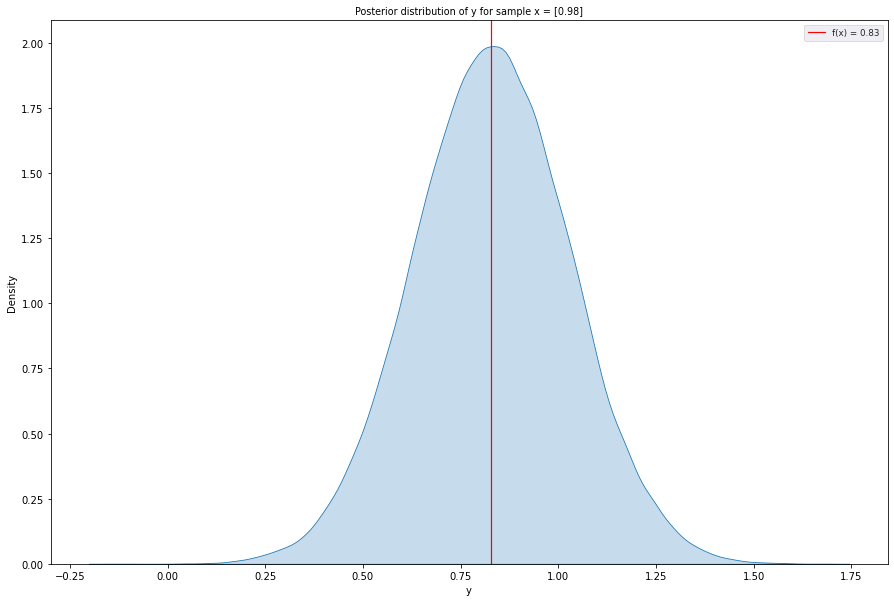

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])


In [6]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([10000, 1]) torch.Size([10000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])


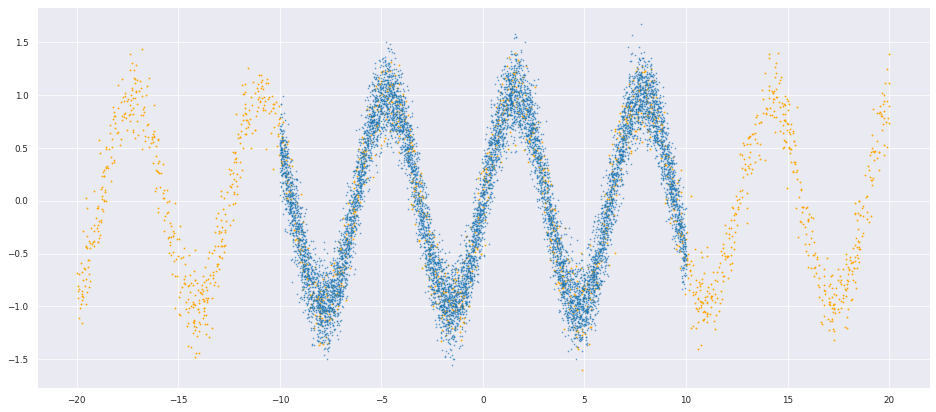

In [7]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test.squeeze(), y_test, color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1, alpha=0.5)


In [8]:
pyro.clear_param_store()

if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    bnn, train_stats = train.train(config, dataset_config, f"{BASE_DIR}")

torch.Size([128, 1]) torch.Size([128, 1])
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Using device: cpu
===== Training profile tyxe-test =====


KeyboardInterrupt: 

Text(0.5, 1.0, 'LL')

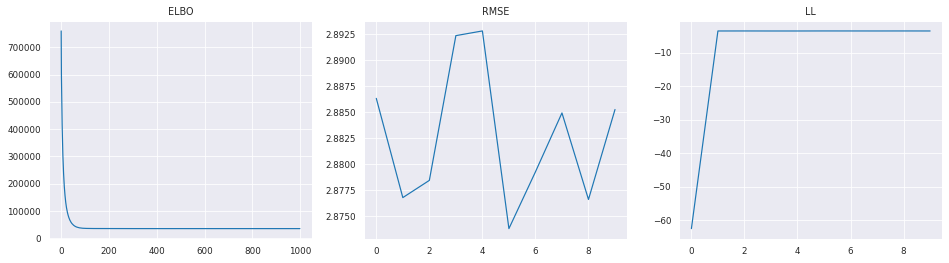

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(train_stats["elbos"])
ax[0].set_title("ELBO")
ax[1].plot(train_stats["rmse_epoch"])
ax[1].set_title("RMSE")
ax[2].plot(train_stats["ll_epoch"])
ax[2].set_title("LL")

In [ ]:
trace = poutine.trace(bnn.guide).get_trace(x_test_in_domain[0], y_test_in_domain[0])

In [ ]:
trace.nodes.keys()

odict_keys(['_INPUT', 'net_guide.net.0.weight.loc', 'net_guide.net.0.weight.scale', 'net.0.weight', 'net_guide.net.0.bias.loc', 'net_guide.net.0.bias.scale', 'net.0.bias', 'net_guide.net.2.0.weight.loc', 'net_guide.net.2.0.weight.scale', 'net.2.0.weight', 'net_guide.net.2.0.bias.loc', 'net_guide.net.2.0.bias.scale', 'net.2.0.bias', 'net_guide.net.3.weight.loc', 'net_guide.net.3.weight.scale', 'net.3.weight', 'net_guide.net.3.bias.loc', 'net_guide.net.3.bias.scale', 'net.3.bias', 'likelihood_guide.likelihood._scale.loc', 'likelihood_guide.likelihood._scale.scale', 'likelihood._scale', '_RETURN'])

In [ ]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

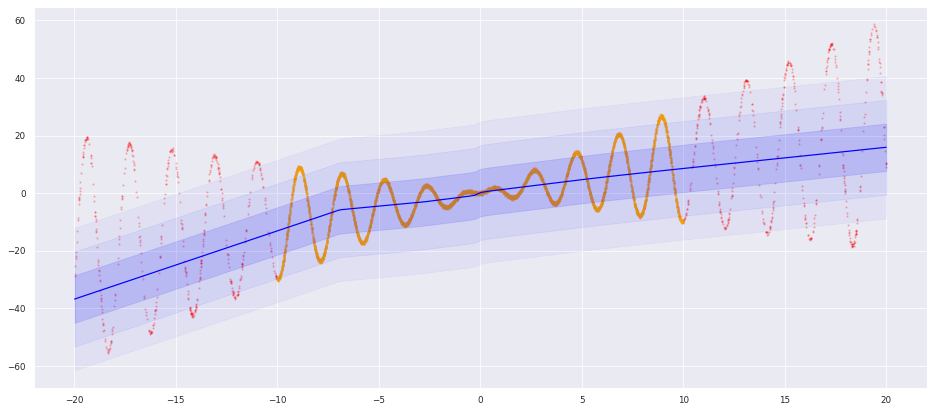

In [ ]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

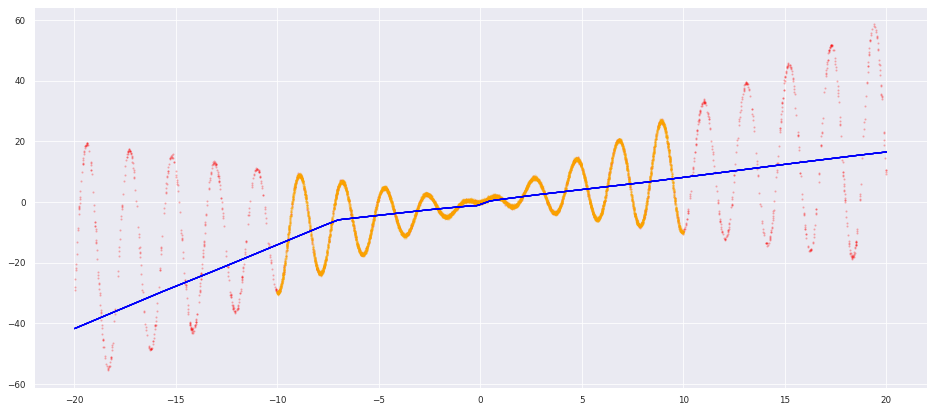

In [ ]:
sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [ ]:

if not os.path.exists(f"{BASE_DIR}/results"):
            os.mkdir(f"{BASE_DIR}/results")           
eval.eval(config, dataset_config, f"{BASE_DIR}", bnn=bnn)

using device: cpu
====== evaluating profile tyxe-test ======
data samples:  (1000, 1000)
pred samples:  (1000, 1000)
Eval done in 0:00:12.275637


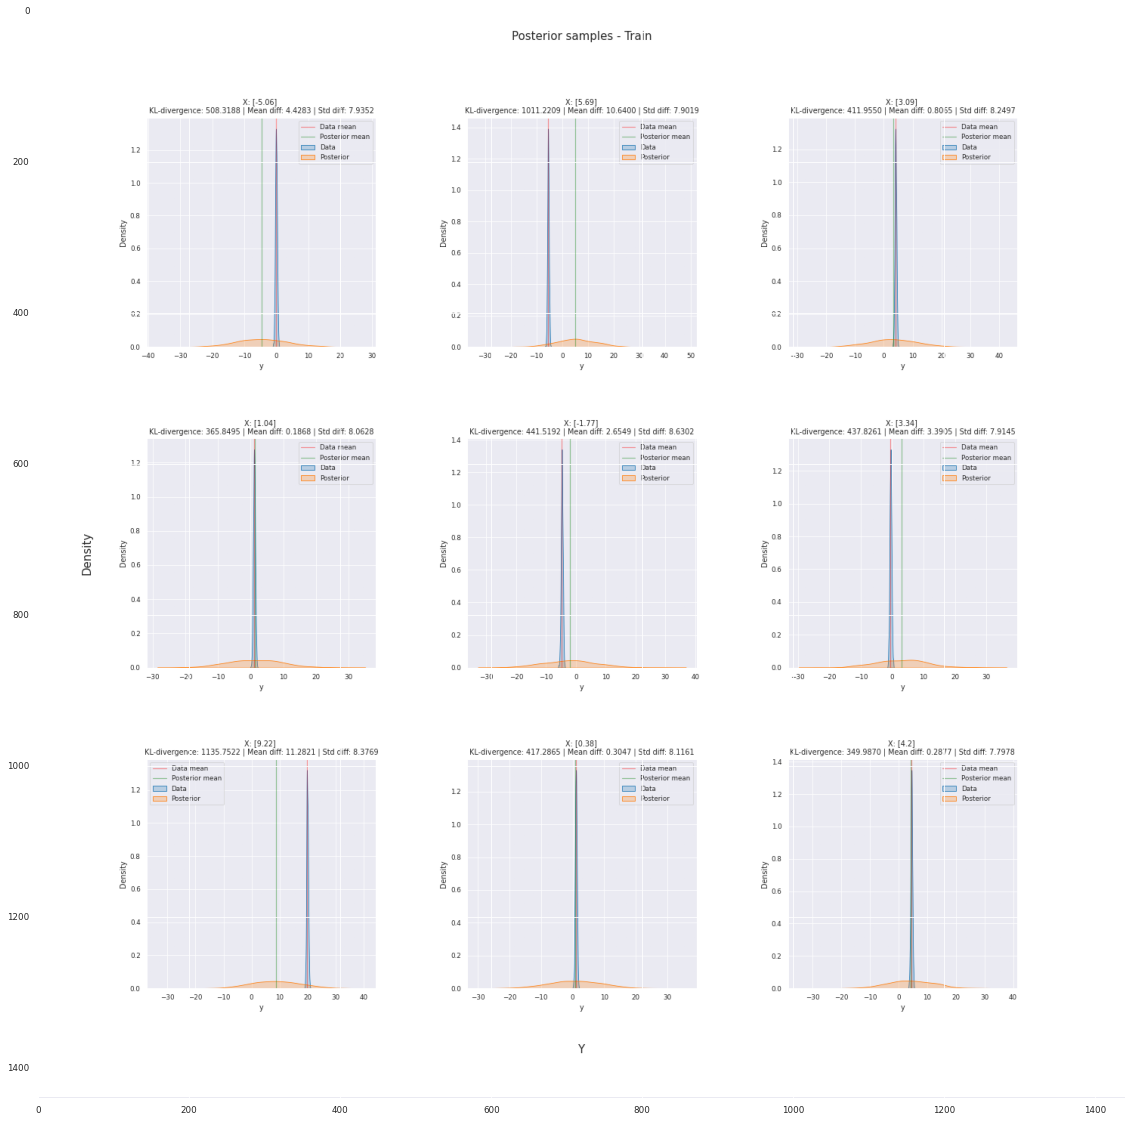

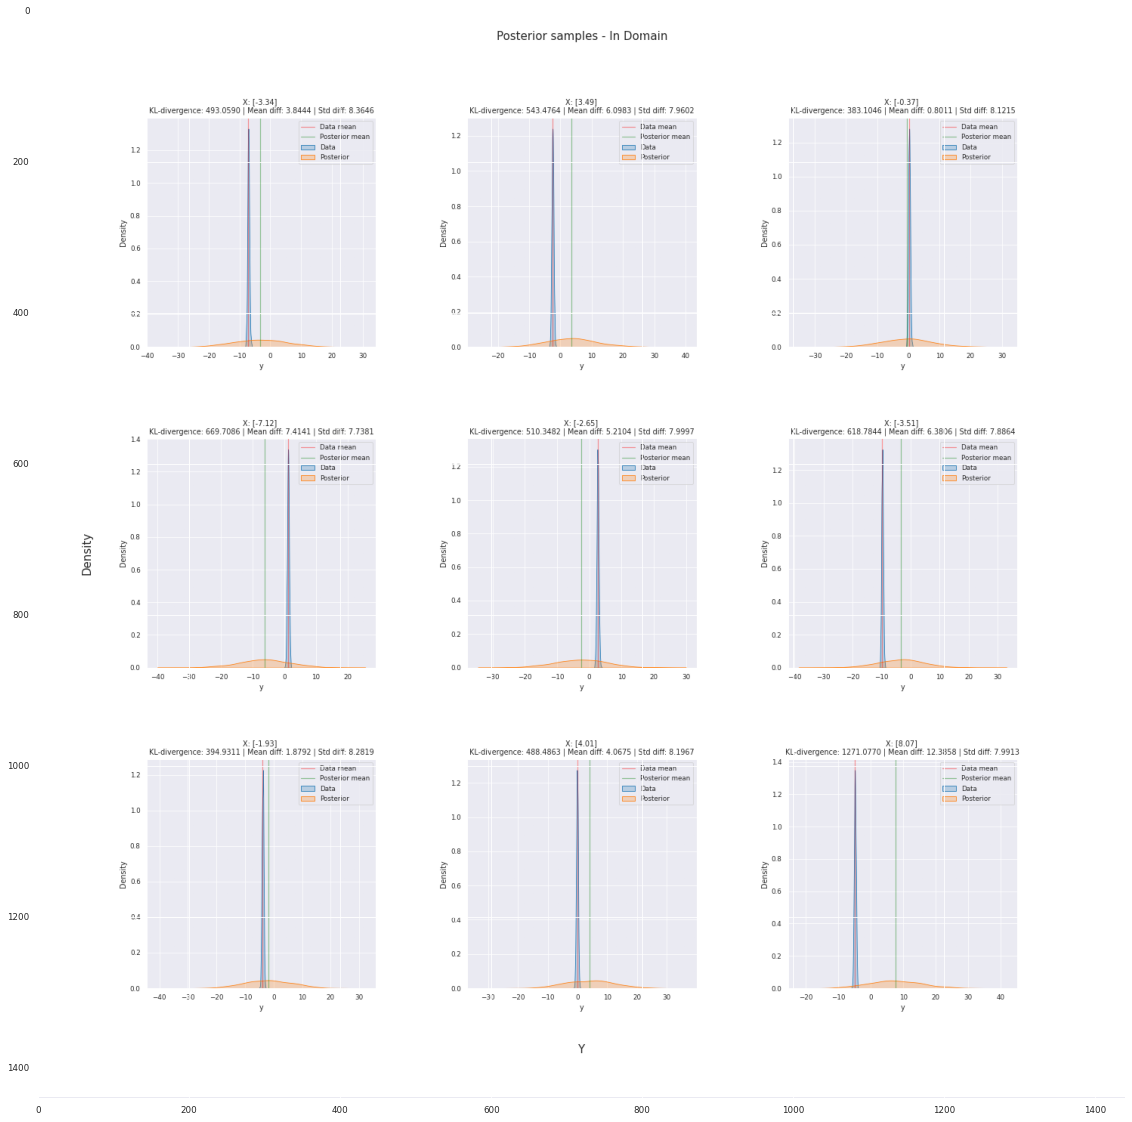

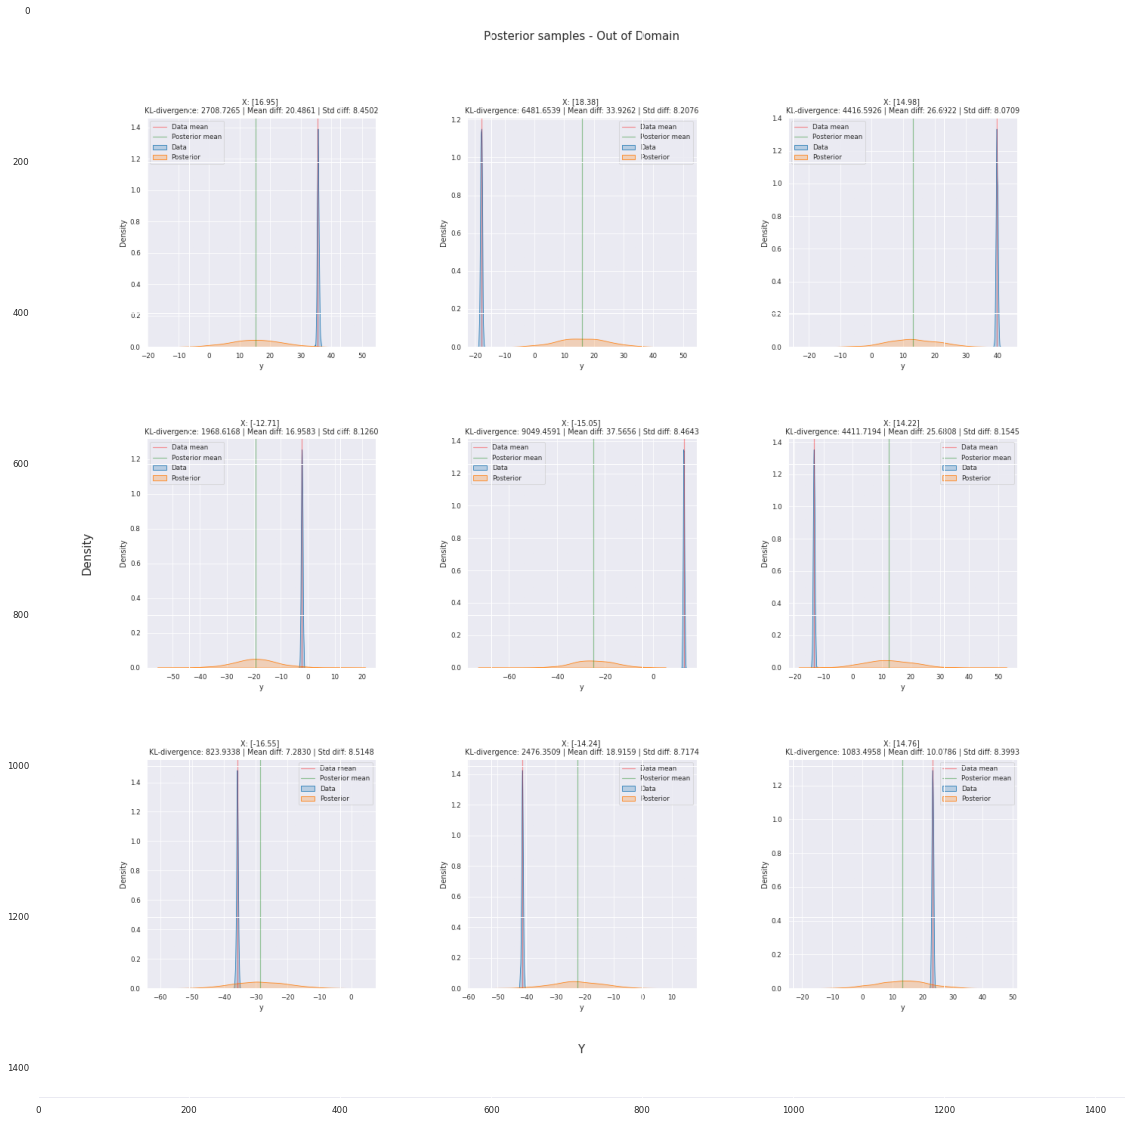

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread(f"{BASE_DIR}/results/{NAME}/train_sanity.png"))

plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread(f"{BASE_DIR}/results/{NAME}/test_in_domain_sanity.png"))

plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread(f"{BASE_DIR}/results/{NAME}/test_out_domain_sanity.png"))